In [1]:
# Python 3
import http.client, urllib.parse
import json
import pprint
import yfinance
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.linear_model as SKmodels
import joblib

# API keys

In [2]:
API_STOCK_DATA = "Ab0Eq9OSOkVaNe9eluoMjkxSgnrFk46h08ghta6w"
API_ALPHA_VANTAGE = "Y55JGW1SYPKKETDD"

# Stock data API

In [3]:
# conn = http.client.HTTPSConnection('api.stockdata.org')
#
# params = urllib.parse.urlencode({
#     'api_token': API_STOCK_DATA,
#     'symbols': 'AAPL',
#     'interval': 'minute',
#     'date_from': '2021-01-01',
#     'date_to': '2022-01-01'
#     })
#
# conn.request('GET', '/v1/data/intraday?{}'.format(params))
#
# res = conn.getresponse()
# data = res.read()
# json.loads(data.decode('utf-8'))

# Alpha vantage

In [4]:
# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey={API_ALPHA_VANTAGE}'
# r = requests.get(url)
# dataVIX = r.json()
# dataVIX

# Yfinance

,VIX_Open
Datetime,
2022-04-21 14:31:00+01:00,19.920000
2022-04-21 14:32:00+01:00,19.870001
2022-04-21 14:33:00+01:00,19.860001
2022-04-21 14:34:00+01:00,19.860001
2022-04-21 14:35:00+01:00,19.920000
...,...
2022-04-29 20:56:00+01:00,34.090000
2022-04-29 20:57:00+01:00,34.180000
2022-04-29 20:58:00+01:00,34.340000


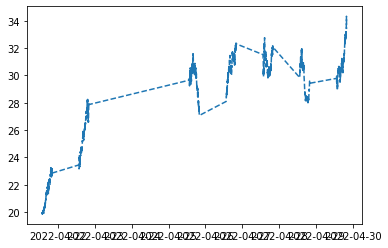

In [5]:
# Download VIX information
ticker = yfinance.Ticker('^VIX')
VIX = ticker.history(interval='1m', period='7d')
VIX.index = pd.to_datetime(VIX.index).tz_convert(tz='Europe/London')
VIX.columns = [f"VIX_{_}" for _ in VIX.columns]
plt.plot(VIX.VIX_Open, '--')
VIX = VIX[["VIX_Open"]]
VIX

,CHFJPY_Open
Datetime,
2022-04-21 00:00:00+01:00,134.860001
2022-04-21 00:01:00+01:00,134.858002
2022-04-21 00:02:00+01:00,134.809998
2022-04-21 00:03:00+01:00,134.811005
2022-04-21 00:04:00+01:00,134.822006
...,...
2022-04-29 21:55:00+01:00,133.414993
2022-04-29 21:56:00+01:00,133.399002
2022-04-29 21:57:00+01:00,133.380005


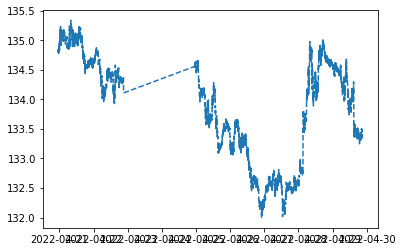

In [6]:
# Download CHFJPY information
ticker = yfinance.Ticker('CHFJPY=X')
CHFJPY = ticker.history(interval='1m', period='7d').iloc[:-15]
CHFJPY.index = pd.to_datetime(CHFJPY.index).tz_convert(tz='Europe/London')
CHFJPY.columns = [f"CHFJPY_{_}" for _ in CHFJPY.columns]
plt.plot(CHFJPY.CHFJPY_Open, '--')
CHFJPY = CHFJPY[["CHFJPY_Open"]]
CHFJPY

,GOLD_Open
Datetime,
2022-04-22 05:00:00+01:00,1952.199951
2022-04-22 05:01:00+01:00,1952.400024
2022-04-22 05:02:00+01:00,1952.199951
2022-04-22 05:03:00+01:00,1952.300049
2022-04-22 05:04:00+01:00,1952.199951
...,...
2022-04-29 21:40:00+01:00,1898.199951
2022-04-29 21:41:00+01:00,1898.000000
2022-04-29 21:42:00+01:00,1897.599976


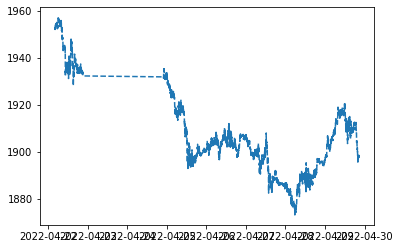

In [7]:
# Download Gold information
ticker = yfinance.Ticker('GC=F')
GOLD = ticker.history(interval='1m', period='7d').iloc[:-15]
GOLD.index = pd.to_datetime(GOLD.index).tz_convert(tz='Europe/London')
GOLD.columns = [f"GOLD_{_}" for _ in GOLD.columns]
plt.plot(GOLD.GOLD_Open, '--')
GOLD = GOLD[["GOLD_Open"]]
GOLD

In [8]:
# Merge both dataFrames. Cut part with causes by yahooFinance shift of VIX
merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
# merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
#              'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
#              'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
#             axis=1, inplace=True)

del nan
# Create Mean by rolling on rollParam value.
rollParam = 100
CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
merged['CHFJPY_Vol'] = CHFJPY_roll.std()
merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

VIX_roll = merged.rolling(rollParam)['VIX_Open']
merged['VIX_Vol'] = VIX_roll.std()
merged['VIX_Mean'] = VIX_roll.mean()

GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
merged['GOLD_Vol'] = GOLD_roll.std()
merged['GOLD_Mean'] = GOLD_roll.mean()

merged = merged.iloc[rollParam:]

predictionMean = 10
merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
merged = merged.iloc[:-predictionMean]
del CHFJPY_roll, VIX_roll, GOLD_roll

merged

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1481/296508333.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future
Datetime,,,,,,,,,,,,
2022-04-22 06:40:00+01:00,134.399994,22.850000,True,1953.599976,False,0.130624,134.45613,0.000000,22.850000,0.770602,1953.654000,134.42812
2022-04-22 06:41:00+01:00,134.389999,22.850000,True,1953.500000,False,0.129084,134.45339,0.000000,22.850000,0.760304,1953.665000,134.42475
2022-04-22 06:42:00+01:00,134.380005,22.850000,True,1953.900024,False,0.127569,134.45058,0.000000,22.850000,0.746088,1953.682001,134.42138
2022-04-22 06:43:00+01:00,134.371994,22.850000,True,1953.800049,False,0.125697,134.44751,0.000000,22.850000,0.732987,1953.697001,134.41804
2022-04-22 06:44:00+01:00,134.380005,22.850000,True,1953.800049,False,0.123459,134.44441,0.000000,22.850000,0.717273,1953.713002,134.41418
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 21:45:00+01:00,133.488998,33.400002,True,1897.900024,True,0.053165,133.40119,0.365696,33.236801,3.116793,1899.889998,133.41289
2022-04-29 21:46:00+01:00,133.490997,33.400002,True,1897.900024,True,0.053503,133.40274,0.358590,33.245701,3.021354,1899.791998,133.41344
2022-04-29 21:47:00+01:00,133.494003,33.400002,True,1897.900024,True,0.053677,133.40444,0.352538,33.253901,2.919480,1899.693999,133.41369


In [9]:
# merged['Target'] = 1 if (merged['CHFJPY_Mean_Future'] > merged['CHFJPY_Mean']) else 0
merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)
# merged['Target'] = merged.apply(lambda x: x.CHFJPY_Mean_Future - x['CHFJPY_Mean'], axis=1)
merged.to_csv('data.csv')

In [10]:
train, test = train_test_split(merged, shuffle=False)
scalePandas = MinMaxScaler()
train[train.columns] = scalePandas.fit_transform(train[train.columns])
train


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future,Target
Datetime,,,,,,,,,,,,,
2022-04-22 06:40:00+01:00,0.806092,0.000000,1.0,0.956056,0.0,0.269572,0.872727,0.000000e+00,0.000000,0.097698,0.979490,0.862028,0.0
2022-04-22 06:41:00+01:00,0.802745,0.000000,1.0,0.954869,0.0,0.265708,0.871680,0.000000e+00,0.000000,0.095963,0.979628,0.860740,0.0
2022-04-22 06:42:00+01:00,0.799398,0.000000,1.0,0.959620,0.0,0.261905,0.870607,0.000000e+00,0.000000,0.093568,0.979843,0.859453,0.0
2022-04-22 06:43:00+01:00,0.796715,0.000000,1.0,0.958432,0.0,0.257207,0.869434,0.000000e+00,0.000000,0.091360,0.980032,0.858177,0.0
2022-04-22 06:44:00+01:00,0.799398,0.000000,1.0,0.958432,0.0,0.251590,0.868250,0.000000e+00,0.000000,0.088713,0.980233,0.856703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 12:20:00+01:00,0.760551,0.930444,1.0,0.194774,0.0,0.385192,0.779148,7.531670e-07,0.974585,0.154753,0.171742,0.773055,0.0
2022-04-28 12:21:00+01:00,0.783654,0.930444,1.0,0.199525,0.0,0.378891,0.778395,7.531670e-07,0.974585,0.154753,0.171742,0.772627,0.0
2022-04-28 12:22:00+01:00,0.802076,0.930444,1.0,0.198338,0.0,0.370328,0.777608,7.531670e-07,0.974585,0.154785,0.171754,0.772100,0.0


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1481/3772619759.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1481/3772619759.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)


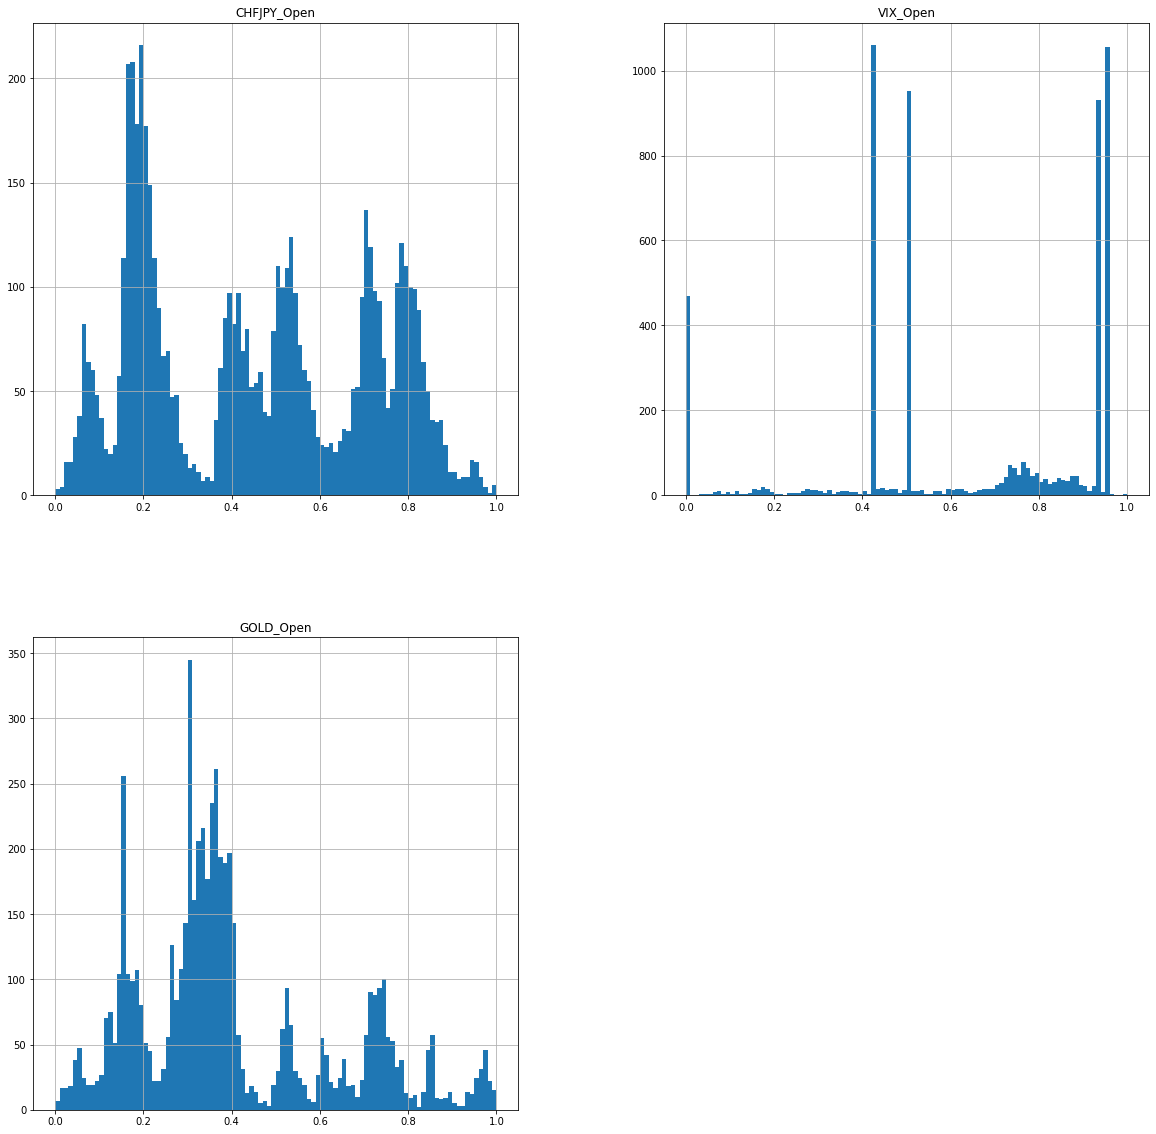

array([[<AxesSubplot:title={'center':'CHFJPY_Vol'}>,
        <AxesSubplot:title={'center':'VIX_Vol'}>],
       [<AxesSubplot:title={'center':'GOLD_Vol'}>, <AxesSubplot:>]],
      dtype=object)

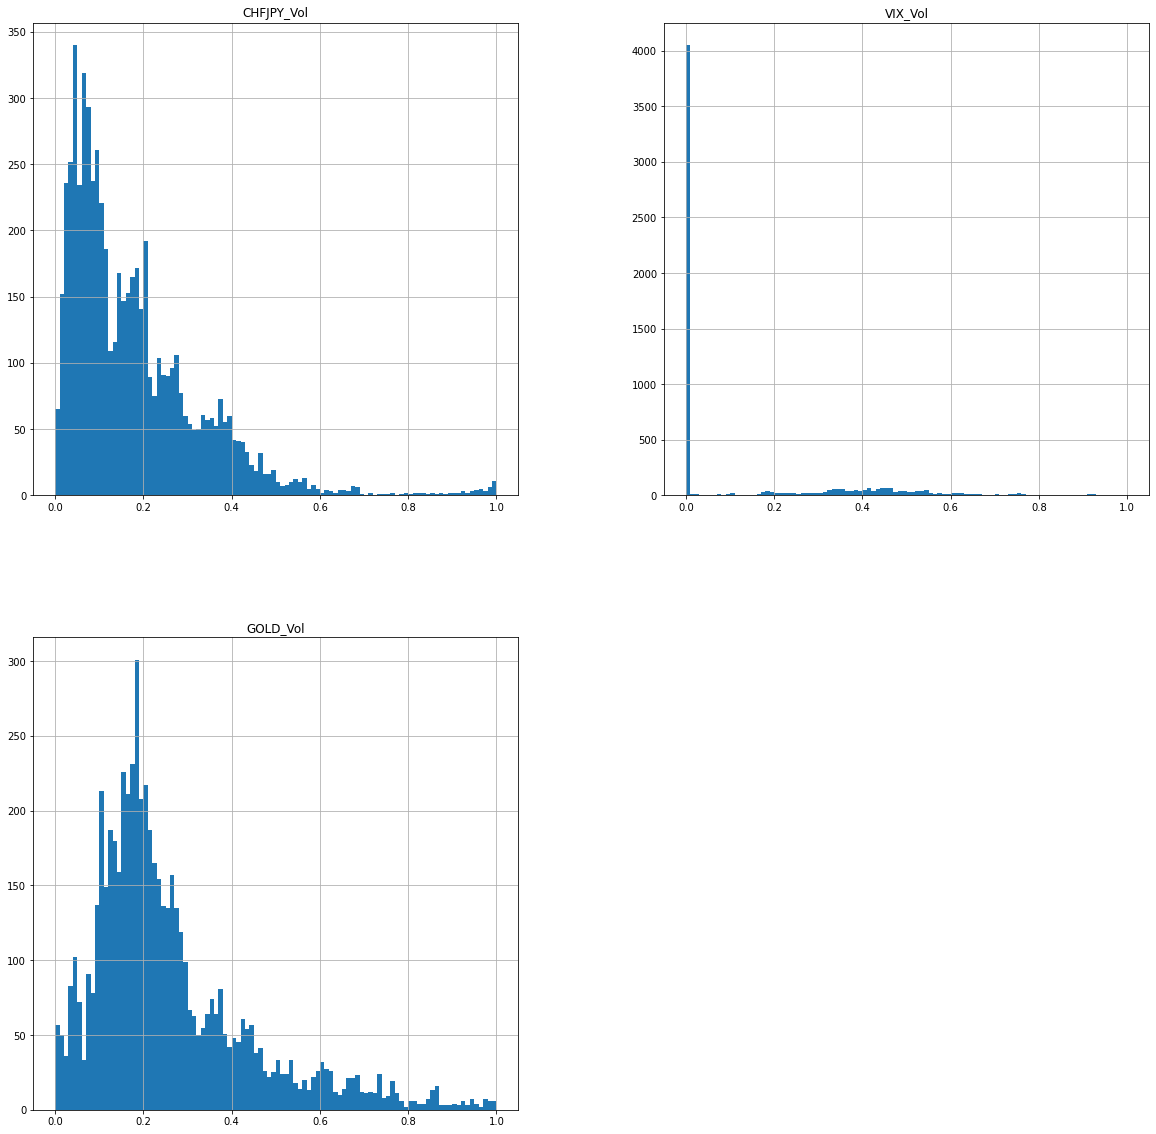

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.set_title('Open Histogram')
train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
plt.show()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)

# Train Batch

In [12]:
trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = trainShifted.columns
for sf in SHIFT_ARRAY:
    shifted = trainShifted.shift(sf)
    for column in trainColumns:
        trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
train = train.iloc[max(SHIFT_ARRAY):]
train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)
train

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1481/1358549267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-22 07:40:00+01:00,0.732415,0.000000,1.0,0.984560,0.0,0.182818,0.796279,0.000000e+00,0.000000,0.192257,...,0.000000e+00,0.000000,0.060068,0.983282,0.872727,0.269572,0.000000e+00,0.000000,0.097698,0.979490
2022-04-22 07:41:00+01:00,0.743468,0.000000,1.0,0.984560,0.0,0.181055,0.795648,0.000000e+00,0.000000,0.192865,...,0.000000e+00,0.000000,0.064435,0.983547,0.871680,0.265708,0.000000e+00,0.000000,0.095963,0.979628
2022-04-22 07:42:00+01:00,0.739114,0.000000,1.0,0.980996,0.0,0.180513,0.795125,0.000000e+00,0.000000,0.193195,...,0.000000e+00,0.000000,0.072016,0.983862,0.870607,0.261905,0.000000e+00,0.000000,0.093568,0.979843
2022-04-22 07:43:00+01:00,0.731413,0.000000,1.0,0.976247,0.0,0.180352,0.794522,0.000000e+00,0.000000,0.192383,...,0.000000e+00,0.000000,0.076801,0.984114,0.869434,0.257207,0.000000e+00,0.000000,0.091360,0.980032
2022-04-22 07:44:00+01:00,0.722036,0.000000,1.0,0.979809,0.0,0.181589,0.794010,0.000000e+00,0.000000,0.192262,...,0.000000e+00,0.000000,0.086013,0.984592,0.868250,0.251590,0.000000e+00,0.000000,0.088713,0.980233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 12:20:00+01:00,0.760551,0.930444,1.0,0.194774,0.0,0.385192,0.779148,7.531670e-07,0.974585,0.154753,...,7.531670e-07,0.974585,0.176647,0.165745,0.916061,0.530241,7.531670e-07,0.974585,0.176464,0.165657
2022-04-28 12:21:00+01:00,0.783654,0.930444,1.0,0.199525,0.0,0.378891,0.778395,7.531670e-07,0.974585,0.154753,...,7.531670e-07,0.974585,0.175359,0.165909,0.913269,0.544870,7.531670e-07,0.974585,0.170521,0.165858
2022-04-28 12:22:00+01:00,0.802076,0.930444,1.0,0.198338,0.0,0.370328,0.777608,7.531670e-07,0.974585,0.154785,...,7.531670e-07,0.974585,0.175121,0.166073,0.910603,0.558108,7.531670e-07,0.974585,0.168942,0.165921


# Test Batch

In [13]:
testB = test
testB[testB.columns] = scalePandas.transform(testB[testB.columns])
testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = testShifted.columns
for sf in SHIFT_ARRAY:
    shifted = testShifted.shift(sf)
    for column in trainColumns:
        testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
testB = testB.iloc[max(SHIFT_ARRAY):]
testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
testB

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1481/264019191.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-28 13:25:00+01:00,0.769254,0.930444,1.0,0.127079,0.0,0.258753,0.809281,7.531670e-07,0.974585,0.296357,...,7.531670e-07,0.974585,0.130530,0.169839,0.775721,0.352659,7.531670e-07,0.974585,0.153234,0.171515
2022-04-28 13:26:00+01:00,0.769928,0.930444,1.0,0.131829,0.0,0.255809,0.809938,7.531670e-07,0.974585,0.303855,...,7.531670e-07,0.974585,0.131771,0.169965,0.774977,0.346475,7.531670e-07,0.974585,0.152173,0.171389
2022-04-28 13:27:00+01:00,0.776622,0.930444,1.0,0.123516,0.0,0.251816,0.810771,7.531670e-07,0.974585,0.313014,...,7.531670e-07,0.974585,0.133650,0.170243,0.774526,0.342573,7.531670e-07,0.974585,0.150186,0.171175
2022-04-28 13:28:00+01:00,0.772606,0.930444,1.0,0.117577,0.0,0.245170,0.811757,7.531670e-07,0.974585,0.324117,...,7.531670e-07,0.974585,0.134445,0.170343,0.774110,0.338172,7.531670e-07,0.974585,0.147660,0.170986
2022-04-28 13:29:00+01:00,0.771599,0.930444,1.0,0.119952,0.0,0.238666,0.812700,7.531670e-07,0.974585,0.333638,...,7.531670e-07,0.974585,0.135589,0.170469,0.773701,0.333507,7.531670e-07,0.974585,0.143037,0.170734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 21:45:00+01:00,0.501004,1.063508,1.0,0.294537,1.0,0.075184,0.469769,3.381606e-01,1.096730,0.492961,...,6.199887e-01,1.040726,0.875917,0.368743,0.453993,0.044649,6.058927e-01,0.991426,0.662027,0.402129
2022-04-29 21:46:00+01:00,0.501674,1.063508,1.0,0.294537,1.0,0.076034,0.470361,3.315897e-01,1.097670,0.476882,...,6.139197e-01,1.042668,0.878904,0.366916,0.454024,0.044570,6.026610e-01,0.993432,0.673360,0.400718
2022-04-29 21:47:00+01:00,0.502680,1.063508,1.0,0.294537,1.0,0.076469,0.471010,3.259934e-01,1.098536,0.459719,...,6.069694e-01,1.044632,0.881403,0.365128,0.453925,0.044358,6.009742e-01,0.995407,0.685048,0.399370


# Forest

In [14]:
data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
target = train.Target
testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
testTarget = testB.Target

In [15]:
forest = RandomForestRegressor(verbose=1, n_estimators=20, min_samples_leaf=43, n_jobs=-1,
                                max_depth=34, min_samples_split=40)
forest.fit(X=data, y=target)
# Train Score
# print('Train Score', forest.score(X=data, y=target))
print('Train Score', forest.score(X=data, y=target))
# Test Score
print('Test Score', forest.score(X=testData, y=testTarget))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Train Score 0.8048625632363218
Test Score 0.07329028143372196


# Ridge Classifier

In [22]:
classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
classifier.fit(X=data, y=target)
# Train Score
print('Train Score', classifier.score(X=data, y=target))
# Test Score
print('Test Score', classifier.score(X=testData, y=testTarget))

Train Score 0.8474776446769023
Test Score 0.8657024793388429


SyntaxError: invalid syntax (1459064666.py, line 2)

[(3.6556246291352967, 'CHFJPY_Open'),
 (-0.7526940435904134, 'VIX_Open'),
 (0.024168941299958693, 'FiniteVixData'),
 (-0.1989866734913311, 'GOLD_Open'),
 (0.03490021732399664, 'FiniteGOLDData'),
 (-0.17153780385875148, 'CHFJPY_Vol'),
 (0.6994330286735799, 'CHFJPY_Mean'),
 (-0.3867521020757534, 'VIX_Vol'),
 (-0.09222905952228179, 'VIX_Mean'),
 (-0.10782223759079901, 'GOLD_Vol'),
 (-0.09270128065917825, 'GOLD_Mean'),
 (0.2922088828097001, 'CHFJPY_Mean_Future'),
 (-0.018407979504644473, 'SHIFTED_5_CHFJPY_Mean'),
 (-0.05888784146960763, 'SHIFTED_5_CHFJPY_Vol'),
 (-0.029419160775014774, 'SHIFTED_5_VIX_Vol'),
 (-0.016415024642363444, 'SHIFTED_5_VIX_Mean'),
 (-0.06850314308048298, 'SHIFTED_5_GOLD_Vol'),
 (-0.056540468786538754, 'SHIFTED_5_GOLD_Mean'),
 (0.11626187409494376, 'SHIFTED_10_CHFJPY_Mean'),
 (0.1352751052830098, 'SHIFTED_10_CHFJPY_Vol'),
 (0.019631482102645797, 'SHIFTED_10_VIX_Vol'),
 (0.05130649594286765, 'SHIFTED_10_VIX_Mean'),
 (-0.04459932569046479, 'SHIFTED_10_GOLD_Vol'),
 (-0.

In [24]:
pd.Series(index=list(train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).columns), data=classifier.coef_[0])

CHFJPY_Open               7.311249
VIX_Open                 -1.505388
FiniteVixData             0.048338
GOLD_Open                -0.397973
FiniteGOLDData            0.069800
CHFJPY_Vol               -0.343076
CHFJPY_Mean               1.398866
VIX_Vol                  -0.773504
VIX_Mean                 -0.184458
GOLD_Vol                 -0.215644
GOLD_Mean                -0.185403
SHIFTED_5_CHFJPY_Mean     0.584418
SHIFTED_5_CHFJPY_Vol     -0.036816
SHIFTED_5_VIX_Vol        -0.117776
SHIFTED_5_VIX_Mean       -0.058838
SHIFTED_5_GOLD_Vol       -0.032830
SHIFTED_5_GOLD_Mean      -0.137006
SHIFTED_10_CHFJPY_Mean   -0.113081
SHIFTED_10_CHFJPY_Vol     0.232524
SHIFTED_10_VIX_Vol        0.270550
SHIFTED_10_VIX_Mean       0.039263
SHIFTED_10_GOLD_Vol       0.102613
SHIFTED_10_GOLD_Mean     -0.089199
SHIFTED_15_CHFJPY_Mean   -0.700691
SHIFTED_15_CHFJPY_Vol     0.274940
SHIFTED_15_VIX_Vol        0.404238
SHIFTED_15_VIX_Mean       0.108302
SHIFTED_15_GOLD_Vol       0.140037
SHIFTED_15_GOLD_Mean

In [25]:
print(classifier.predict(testData))

[1. 1. 1. ... 1. 1. 1.]


In [26]:
classifier = SKmodels.LogisticRegression(penalty='elasticnet', l1_ratio=0.4, C=0.5, solver='saga')
classifier.fit(X=trainShifted.values, y=train.Target)
# Train Score
print('Train Score', classifier.score(X=trainShifted.values, y=train.Target))
# Test Score
print('Test Score', classifier.score(X=testShifted.values, y=testB.Target))

Train Score 0.800911084865868
Test Score 0.7510330578512396


In [34]:
import warnings


def make_score(value):
    warnings.filterwarnings("ignore")
    merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

    merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
    # merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
    #              'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
    #              'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
    #             axis=1, inplace=True)

    del nan
    # Create Mean by rolling on rollParam value.
    rollParam = value
    CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
    merged['CHFJPY_Vol'] = CHFJPY_roll.std()
    merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

    VIX_roll = merged.rolling(rollParam)['VIX_Open']
    merged['VIX_Vol'] = VIX_roll.std()
    merged['VIX_Mean'] = VIX_roll.mean()

    GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
    merged['GOLD_Vol'] = GOLD_roll.std()
    merged['GOLD_Mean'] = GOLD_roll.mean()

    merged = merged.iloc[rollParam:]

    predictionMean = value
    merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
    merged = merged.iloc[:-predictionMean]
    del CHFJPY_roll, VIX_roll, GOLD_roll
    merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)
    # merged['Target'] = merged.apply(lambda x: x.CHFJPY_Mean_Future - x['CHFJPY_Mean'], axis=1)
    train, test = train_test_split(merged, shuffle=False)
    scalePandas = MinMaxScaler()
    train[train.columns] = scalePandas.fit_transform(train[train.columns])
    trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = trainShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = trainShifted.shift(sf)
        for column in trainColumns:
            trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
    train = train.iloc[max(SHIFT_ARRAY):]
    train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)

    testB = test
    testB[testB.columns] = scalePandas.transform(testB[testB.columns])
    testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = testShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = testShifted.shift(sf)
        for column in trainColumns:
            testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
    testB = testB.iloc[max(SHIFT_ARRAY):]
    testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
    data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    target = train.Target
    testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    testTarget = testB.Target
    classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
    classifier.fit(X=data, y=target)
    return [value, classifier.score(X=testData, y=testTarget)]

with pd.option_context('mode.chained_assignment',None):
    RES = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(make_score)(x) for x in list(range(10, 400, 5)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   13.6s finished


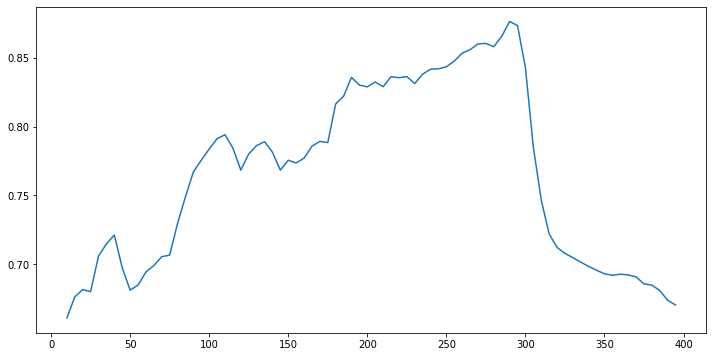

In [35]:
plt.figure(figsize=(12,6))
plt.plot([x[0] for x in RES], [x[1] for x in RES])

In [4]:
import pandas as pd

class Strategy:
    def __init__(self, dataFrame, hoursAvailable='all'):
        self.BASE = 'CHFJPY'
        self.data = dataFrame
        self.data.index = pd.to_datetime(self.data.index)
        self.trainSize = 0.5
        self.TimeBorder = pd.Timedelta('300T')
        self.intTimeBorder = self.TimeBorder // '1T'
        self.Y_threshold = 3    # In sigmas
        self.scanTime = pd.Timedelta('400T')  # For collecting half-time
        self.intScanTime = self.scanTime // '1T'
        self.scanTimeSimplifier = pd.Timedelta('20T')
        self.intScanTimeSimplifier = self.scanTimeSimplifier // '1T'
        if hoursAvailable == 'all':
            self.availableToTradeHours = [i for i in range(0, 25)]
        else:
            self.availableToTradeHours = hoursAvailable
        idxPos = self.data.index
        def _applyer(x, inSID):
            if (idxPos.get_loc(x.name) % inSID.intScanTimeSimplifier != 0):
                return -666
            if (idxPos.get_loc(x.name)) > self.intScanTime:
                POS = idxPos.get_loc(x.name)
                return self.get_half_time(inSID.data[f"{self.BASE}_Open"].iloc[POS-self.intScanTime:POS])
            else:
                return np.nan
        self.data["HalfTime"] = self.data.apply(lambda x: _applyer(x, inSID=self), axis=1)
        self.data["HalfTime"].replace(to_replace = -666,  method='ffill', inplace=True)
    def get_half_time(self, openTuple: pd.Series) -> float:
        """
        Функция отдающая период полураспада
        :param openTuple:
        :return:
        """
        df_open = openTuple.to_frame()
        df_lag = df_open.shift(1)
        df_delta = df_open - df_lag
        linear_regression_model = LinearRegression()
        df_delta = df_delta.values.reshape(len(df_delta), 1)
        df_lag = df_lag.values.reshape(len(df_lag), 1)
        linear_regression_model.fit(df_lag[1:], df_delta[1:])
        half_life = -np.log(2) / linear_regression_model.coef_.item()
        return int(half_life)

    def calculate_half_times(self):
        pass

strategy = Strategy(dataFrame=pd.read_csv('data.csv', index_col=0).iloc[:800])
strategy.data

,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future,Target,HalfTime
Datetime,,,,,,,,,,,,,,
2022-04-22 06:40:00+01:00,134.399994,22.850000,True,1953.599976,False,0.130624,134.45613,0.000000,22.8500,0.770602,1953.654000,134.42812,0,NaN
2022-04-22 06:41:00+01:00,134.389999,22.850000,True,1953.500000,False,0.129084,134.45339,0.000000,22.8500,0.760304,1953.665000,134.42475,0,NaN
2022-04-22 06:42:00+01:00,134.380005,22.850000,True,1953.900024,False,0.127569,134.45058,0.000000,22.8500,0.746088,1953.682001,134.42138,0,NaN
2022-04-22 06:43:00+01:00,134.371994,22.850000,True,1953.800049,False,0.125697,134.44751,0.000000,22.8500,0.732987,1953.697001,134.41804,0,NaN
2022-04-22 06:44:00+01:00,134.380005,22.850000,True,1953.800049,False,0.123459,134.44441,0.000000,22.8500,0.717273,1953.713002,134.41418,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-22 19:57:00+01:00,134.367996,28.160000,False,1935.000000,False,0.085847,134.34039,0.540641,26.9976,0.940275,1935.185002,134.32759,0,37.0
2022-04-22 19:58:00+01:00,134.378998,28.209999,False,1934.599976,False,0.084473,134.33921,0.545164,27.0194,0.942091,1935.179003,134.32582,0,37.0
2022-04-22 19:59:00+01:00,134.369995,28.170000,False,1934.400024,False,0.083648,134.33831,0.548658,27.0404,0.945279,1935.172003,134.32379,0,37.0
